# Yahoo Finance

### Description:

### Resources:
- https://algotrading101.com/learn/yahoo-finance-api-guide/
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
- https://data-flair.training/blogs/stock-price-prediction-machine-learning-project-in-python/
- Seaborn Documentation: https://seaborn.pydata.org/generated/seaborn.scatterplot.html


### Preparations:

In [145]:
# ------------------------- IMPORTS --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from datetime import date
from sklearn import ensemble
from sklearn.ensemble import IsolationForest
# from keras.models import Sequential
# from keras.layers import LSTM,Dropout,Dense # TODO : pip3 install tensorflow
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# ------------------------- DATASET ---------------------------
ds = pd.read_csv('stocks.csv')
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'Ticker']

In [5]:
# ------------------------- ASSIST FUNCTIONS --------------------------
def numeric_date(date):
    d = str(date)
    return int(d[0:4] + d[5:7] + d[8:10])

def getyear_date(date):
    d = str(date)
    return int(d[0:4])

def best_time_formatting(date):
    dt.datetime.strptime(date, "%Y-%m-%d").date()

def plot_xdate(x, y):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(x, y)
    plt.gcf().autofmt_xdate()
    # plt.show()

# ------------------------- DATASET REFORMATTING --------------------------
# ds['Date'] = list(map(lambda x: best_time_formatting(x) ,ds['Date']))
ds['Margin'] = ds['High'] - ds['Low'] #difference between higghest and lowest
ds['Difference'] = abs(ds['Open'] - ds['Close']) #difference between start and close values
ds['Value@Close'] = ds['Volume'] * ds['Close'] #difference between start and close values
ds['PercentChange'] = round(ds['Close'] * 100 / ds['Open'], 3) - 100 #Open Value = 100 %, Close Value = x %
ds['DateOrdinal'] = pd.to_datetime(ds['Date']).apply(lambda x: x.toordinal())
ds['DateOrdinal_plt']  = [dt.datetime.strptime(i, '%Y-%M-%d').toordinal() for i in ds['Date']]



### Analysis:

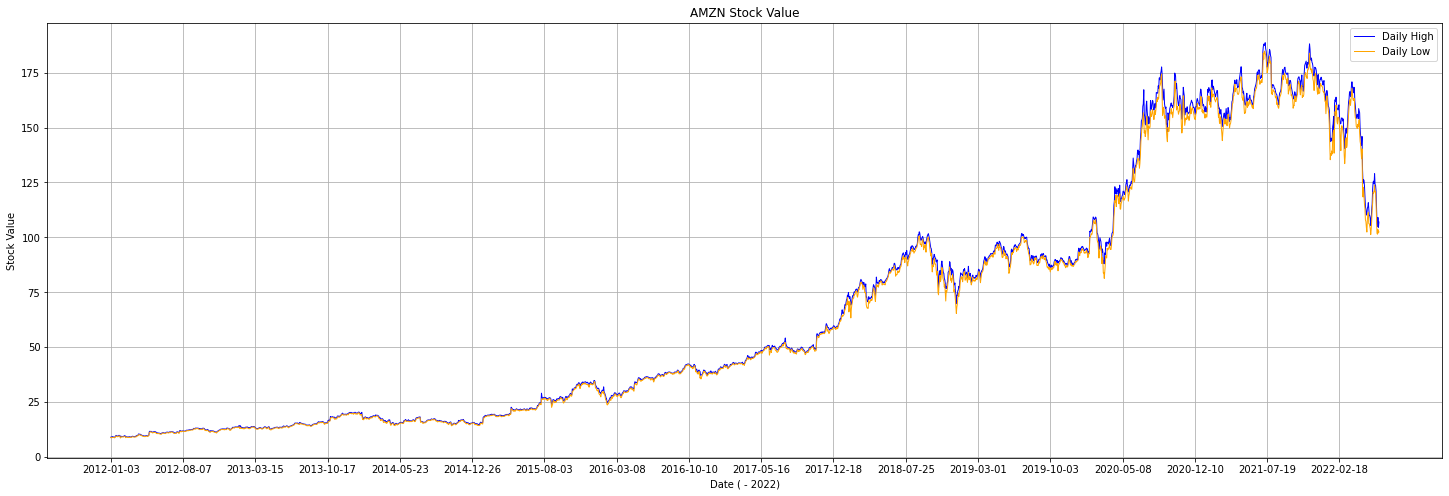

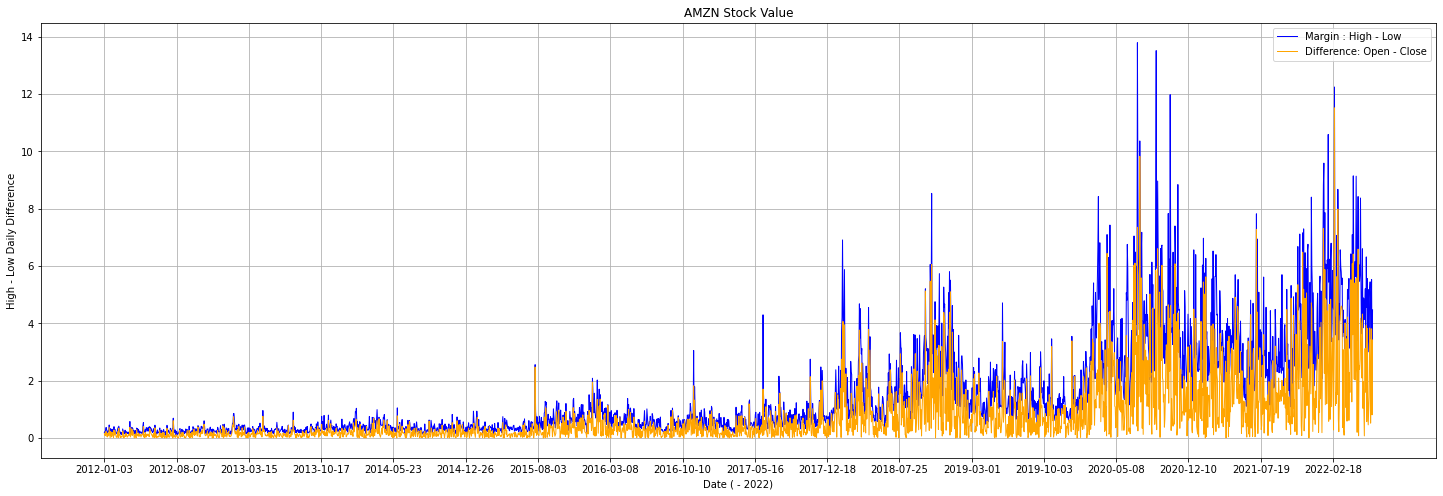

In [6]:
plt.figure(figsize = (25, 8))

ds_ = ds[ds['Ticker'] == 'AMZN']
ds_ = ds_[['Date', 'High', 'Low', 'Difference', 'Margin']]
x, y1, y2, y3, y4 = ds_['Date'], ds_['High'], ds_['Low'], ds_['Margin'], ds_['Difference']


# ------------------------------ VISUALIZATIONS --------------------------

plt.plot(x, y1, linewidth = 1., color = 'blue',  label = 'Daily High')
plt.plot(x, y2, linewidth = 1, color = 'orange', label = 'Daily Low') 
plt.xticks(np.arange(0, len(x)+1, 150))
plt.xlabel('Date ( - 2022)')
plt.ylabel('Stock Value')
plt.title('AMZN Stock Value')
plt.legend(loc = 0, frameon = 'legend_drawn_flag')
plt.grid()


plt.figure(figsize = (25, 8))
plt.plot(x, y3, linewidth = 1, color = 'blue',  label = 'Margin : High - Low')
plt.plot(x, y4, linewidth = 1, color = 'orange', label = 'Difference: Open - Close') 
plt.xticks(np.arange(0, len(x)+1, 150))
plt.xlabel('Date ( - 2022)')
plt.ylabel('High - Low Daily Difference')
plt.title('AMZN Stock Value')
plt.legend(loc = 0, frameon = 'legend_drawn_flag')
plt.grid()

Let's try to find anoamalies within the amazon stock value growth graph

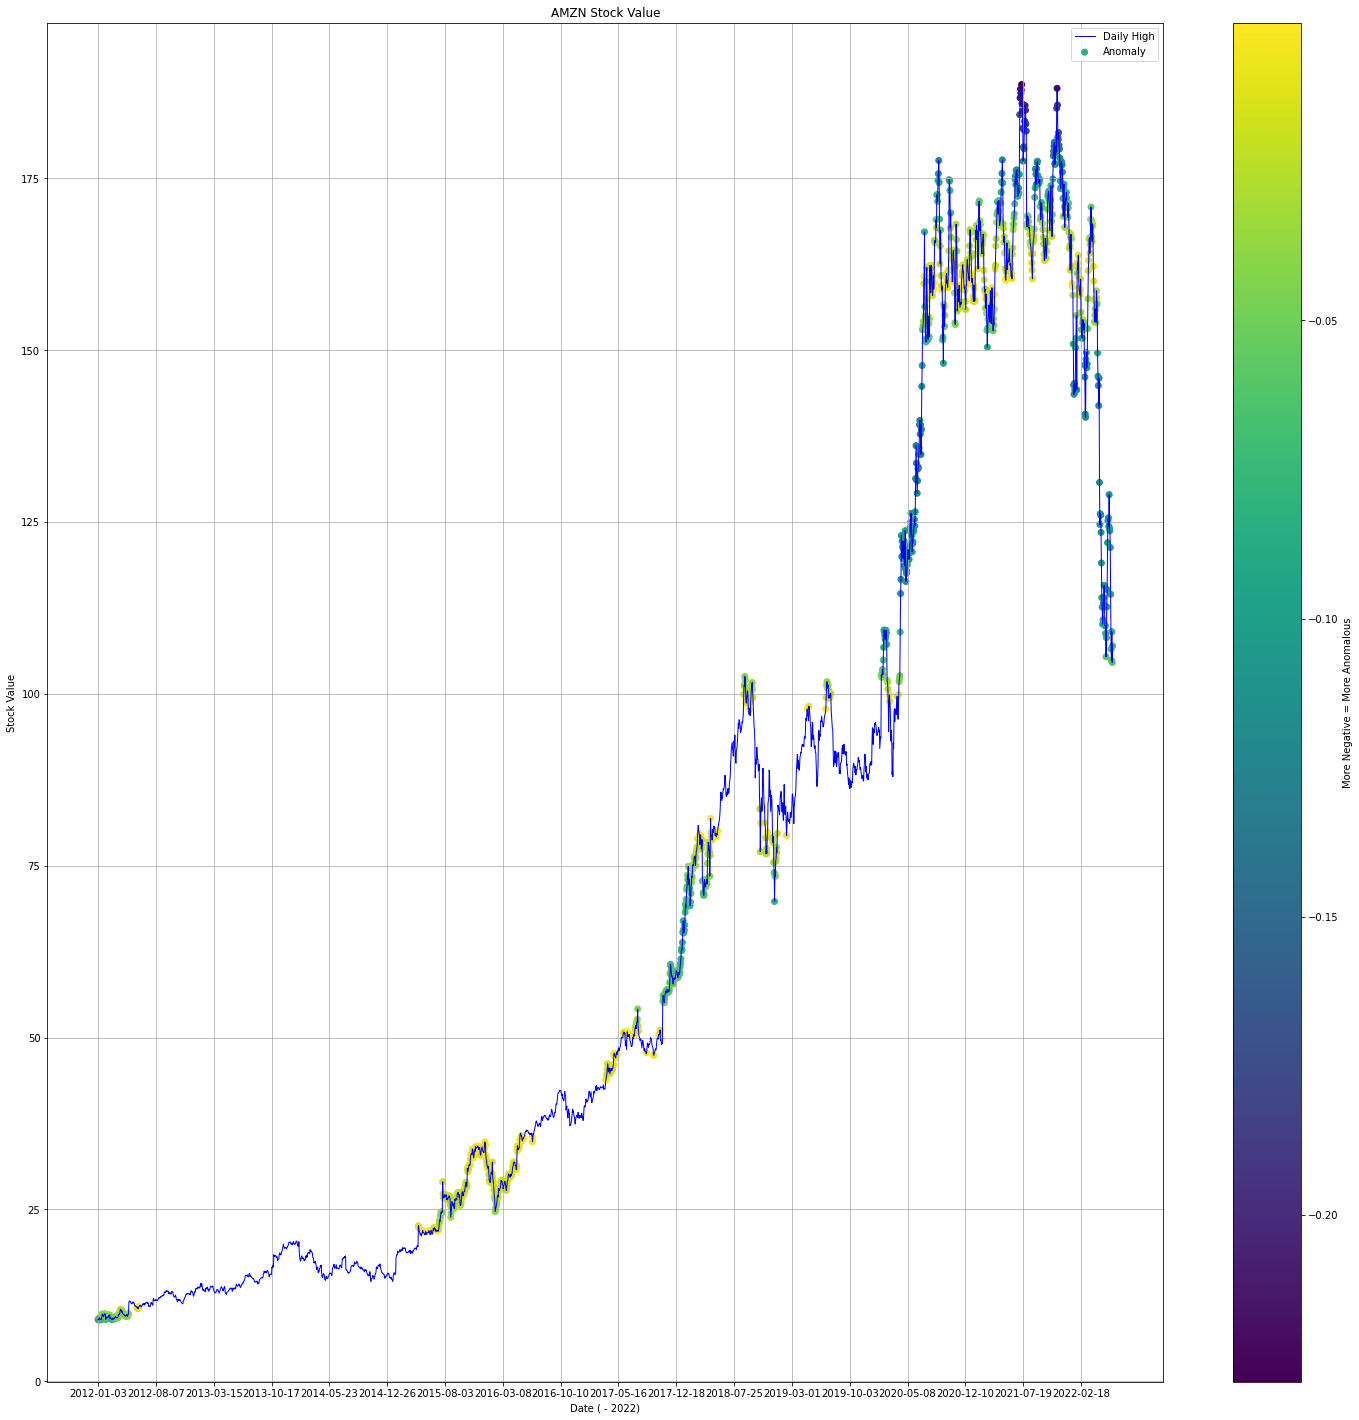

In [7]:
plt.figure(figsize = (25, 25))
model = IsolationForest()
model.fit(ds_[['High', 'Low']])
predictions = model.predict(ds_[['High', 'Low']])
ds_['Anomaly'] = predictions

outliers = ds_[ds_['Anomaly'] == -1]
anomaly_score = model.decision_function(outliers[['High', 'Low']])
plt.plot(x, y1, linewidth = 1., color = 'blue',  label = 'Daily High')
anomaly_scatter = plt.scatter(outliers['Date'], outliers['High'], c = anomaly_score, cmap = 'viridis', marker = 'o', label = 'Anomaly')
plt.colorbar(anomaly_scatter, label = 'More Negative = More Anomalous')
plt.xticks(np.arange(0, len(x)+1, 150))
plt.xlabel('Date ( - 2022)')
plt.ylabel('Stock Value')
plt.title('AMZN Stock Value')
plt.legend(loc = 0, frameon = 'legend_drawn_flag')
plt.grid()


2106/2106 - 6s - loss: 0.0085 - 6s/epoch - 3ms/step
17/17 [==============================] - 1s 1ms/step


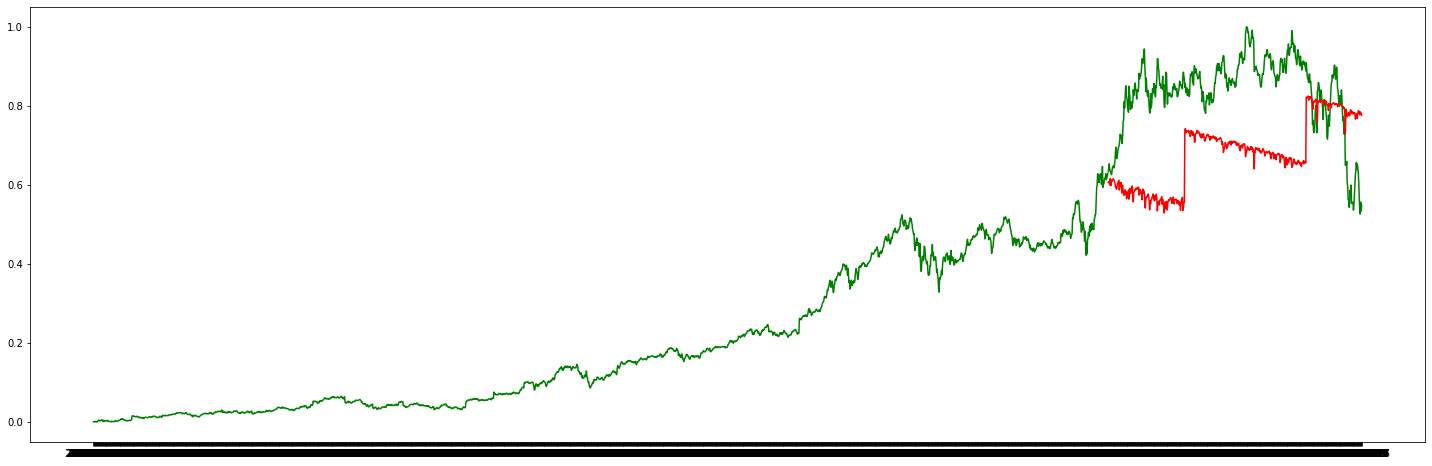

In [144]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

ds_ = ds[ds['Ticker'] == 'AMZN']
ds_ = ds_.sort_values("Date")
ds_ = ds_[['Date', 'Close', 'Volume']]
def days_diff(x):
    y, m, d = int(x[0:4]), int(x[5:7]), int(x[8:10])
    yr = (2022 - y)*365 + 3 #years returned
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    mr = sum(days[0:m])
    return yr + mr + d

sc = MinMaxScaler(feature_range = (0,1))
ds_['Close'] = sc.fit_transform(ds_[['Close']])
ds_['Volume'] = sc.fit_transform(ds_[['Volume']])
# ds_['Date'] = sc.fit_transform(ds_[['Date']])
ds_['Date_Num'] = ds_['Date'].apply(lambda x: days_diff(x))
ds_['Date_Num'] = sc.fit_transform(ds_[['Date_Num']])

ds_ = ds_.sort_values(by = "Date", ascending = True, axis = 0)
train_cut_point = round(len(ds_) * 0.8)
train = ds_[0:train_cut_point]
test = ds_[train_cut_point:]
X_train, y_train, X_test, y_test = train[['Date_Num', 'Volume']], train['Close'], test[['Date_Num', 'Volume']], test['Close']

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (2, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit( X_train, y_train, epochs = 1, batch_size = 1, verbose = 2)

predictions = model.predict(X_test)
plt.figure(figsize = (25, 8))
plt.plot(train['Date'], y_train, color = "green")
plt.plot(test['Date'], y_test, color = "green")
plt.plot(test['Date'], predictions, color = "red")
plt.show()
